# Example: Create Population for West London

This notebook demonstrates an complex example workflow for creating a sample population for an area in West London. It creates agent plans for people and households using a random process.

### Aim: 
Create a bigger and more realistic sample population automatically for the West London area called Londinium. The sample population includes various activities, personal attributes and modes; the population would be used as input for MATSim transport simulation.

- Import geographic data of Londinium.
- Activity generation model with home based tours. Expand agents with different personal attributes, activities and trips.
- Perform Data Visualization and validation. Plot the activity plan, distance and duration of population
- Export intermediate CSV tables of the population

In [1]:
import os
import numpy as np
from random import choice
import pandas as pd
import geopandas as gp
from matplotlib import pyplot as plt
%matplotlib inline
from shapely.geometry import Point

from pam.core import Population, Household, Person
from pam.activity import Plan, Activity, Leg
from pam.utils import minutes_to_datetime as mtdt
from pam.variables import END_OF_DAY
from pam.write import write_matsim, write_od_matrices, to_csv
from pam.report.benchmarks import duration_counts, distance_counts
from pam.plot.stats import plot_activity_times, plot_leg_times
from pam.read import load_travel_diary, read_matsim
from pam.samplers import facility
from pam.write import write_matsim

## Import geographic data of Londinium

In [2]:
# Import geographic data of west london area
network_bb_path = os.path.join("data", "network_bounding_box.geojson")
lsoas_path = os.path.join("data", "lsoas") # lsoas: lower layer super output areas 

We will start by plotting Londinium boundary

<AxesSubplot:>

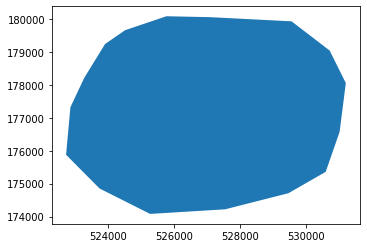

In [3]:
# Read the file and plot the boundary
boundary = gp.read_file(network_bb_path)

# Transform to epsg:27700
boundary = boundary.to_crs("epsg:27700")
boundary.plot()

Next we will plot Londinium outline shown above over a map of London to see where exactly it is located.

EPSG:27700


<AxesSubplot:>

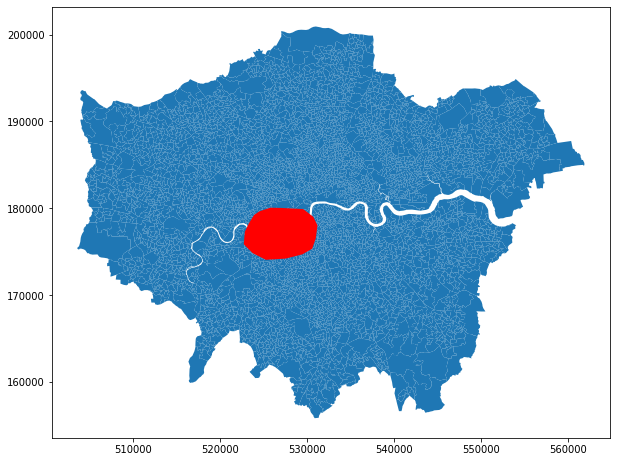

In [4]:
# Plot boundary area in lsoas
lsoas = gp.read_file(lsoas_path)
lsoas.crs = 'EPSG:27700'
print(lsoas.crs)
lsoas = lsoas.set_index("LSOA_CODE")

fig, ax = plt.subplots(figsize=(10,10))
lsoas.plot(ax = ax)
boundary.plot(ax = ax, color='red')

Finally, we will plot Londinium with LSOA boundaries included.

<AxesSubplot:>

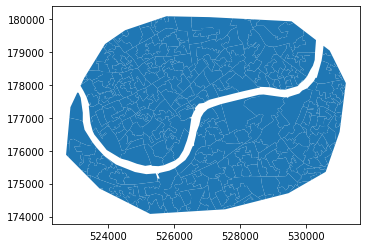

In [5]:
# Overlay the area using geopandas package
lsoas_clipped = gp.overlay(lsoas, boundary, how='intersection')
lsoas_clipped.plot()

In [6]:
lsoas_clipped.head()

,LSOA_NAME,MSOA_CODE,MSOA_NAME,STWARDCODE,STWARDNAME,LA_CODE,LA_NAME,geometry
0,Hammersmith and Fulham 010A,E02000381,Hammersmith and Fulham 010,00ANGA,Addison,00AN,Hammersmith and Fulham,"POLYGON ((523932.247 179242.842, 523959.439 17..."
1,Hammersmith and Fulham 010B,E02000381,Hammersmith and Fulham 010,00ANGA,Addison,00AN,Hammersmith and Fulham,"POLYGON ((524171.272 179363.077, 524212.654 17..."
2,Hammersmith and Fulham 012A,E02000383,Hammersmith and Fulham 012,00ANGC,Avonmore and Brook Green,00AN,Hammersmith and Fulham,"POLYGON ((524167.660 178997.302, 524060.845 17..."
3,Hammersmith and Fulham 012B,E02000383,Hammersmith and Fulham 012,00ANGC,Avonmore and Brook Green,00AN,Hammersmith and Fulham,"POLYGON ((523774.000 178714.003, 523831.847 17..."
4,Hammersmith and Fulham 012C,E02000383,Hammersmith and Fulham 012,00ANGC,Avonmore and Brook Green,00AN,Hammersmith and Fulham,"MULTIPOLYGON (((524422.688 178825.081, 524379...."


# Facility sampler

In [7]:
facilities_path = 'data/londinium_facilities_sample.geojson'
facilities = gp.read_file(facilities_path)
facilities = facilities.rename({'activities': 'activity'}, axis=1)
facilities.crs = 'EPSG:27700'
facilities.head()

,activity,area,distance_to_nearest_education,distance_to_nearest_medical,distance_to_nearest_shop,distance_to_nearest_transit,floor_area,id,levels,units,geometry
0,home,574,617.965594,516.743962,77.712882,466.059745,1148.0,1084822608,2.0,1.0,POINT (524877.659 179721.080)
1,home,66,143.055807,115.674294,125.537224,286.017738,198.0,368319574,3.0,1.0,POINT (527830.357 174758.729)
2,home,103,54.946075,214.532285,41.572871,93.975944,412.0,1640220880,4.0,1.0,POINT (526060.994 178970.515)
3,home,192,164.455318,216.217139,111.674214,180.452314,768.0,1741392588,4.0,1.0,POINT (526698.625 178513.841)
4,home,123,173.648285,249.190465,188.276309,139.258340,246.0,984446626,2.0,1.0,POINT (526369.238 179166.396)


Start by plotting different facility types, e.g. educational and medical facilities

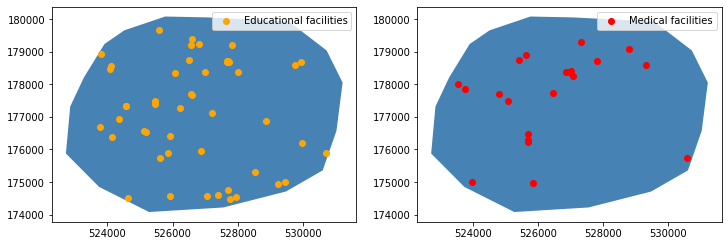

In [8]:
education = facilities[facilities['activity']=='education']
medical = facilities[facilities['activity']=='medical']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))

boundary.plot(ax = ax1, color='steelblue')
education.plot(ax = ax1, color='orange', label = 'Educational facilities')
#lsoas_clipped.plot(ax = ax1)
ax1.legend()

boundary.plot(ax = ax2, color='steelblue')
medical.plot(ax = ax2, color='red', label = 'Medical facilities')
#lsoas_clipped.plot(ax = ax2)
ax2.legend()

In [9]:
# zones = lsoas_clipped
lsoas_clipped.crs = 'EPSG:27700'
len(lsoas_clipped)

306

In [10]:
lsoas_clipped = lsoas_clipped.set_index("LSOA_NAME")

In [11]:
# build the sampler
facility_sampler = facility.FacilitySampler(
    facilities=facilities,
    zones=lsoas_clipped,
    build_xml=True,
    fail=False,
    random_default=True)

Joining facilities data to zones, this may take a while.
/Users/fred.shone/.ve/pam/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

Building sampler, this may take a while.


## Activity generation model

In [12]:
# Create random area sample
def random_area_sampler():
    indexes = list(lsoas_clipped.index)
    return np.random.choice(indexes)

random_area_sampler()  # test

'Kensington and Chelsea 010C'

- It is a simple home based tours within 24 hours. 
- We create different activity types: work, leisure, education, shopping, etc. Different transport model types: car, bus, subway, etc. 
- Random number is assigned to the duration for each activity and transport mode

In [13]:
#mapping the MSOA and LAD with index
mapping_dict = dict(zip(lsoas_clipped.index, lsoas_clipped.MSOA_CODE))
mapping_dict1 = dict(zip(lsoas_clipped.index, lsoas_clipped.LA_NAME))

In [14]:
# Generate agents in west london area
def generate_agents(no_of_agents):
    """
    Randomly create agents with simple home-based tours. 
    The trip starts from home, has a random number of various acitivites, tranport modes would be added. 
    The trip finally ends at home.
    
    """
    
    population = Population() # Initialise an empty population
    
    # Create simple personal attributes
    income = ["low", "medium", "high"]
    gender = ["male", "female"]
    sort_age = ['0 to 4', '5 to 10', '11 to 15', '16 to 20', '21 to 25', '26 to 29',
                '30 to 39', '40 to 49', '50 to 59', '60 to 64',
                '65 to 69', '70 to 74', '75 to 79', '80 to 84', '85  and over']
    
    # Create mode and activities
    transport = ['car', 'bus', 'ferry', 'rail', 'subway', 'bike', 'walk']
    # Removed gym and park due to osmox problem
    activity = ['leisure', 'work', 'shop', 'medical','education', 'park', 'pub', 'gym'] # Primary activity
    sub_activity = ["shop", "medical", "pub", "gym"] # People usually spend less time on sub activity
    
    # Add activity plan for each person
    for i in range(no_of_agents):

        # Create different agents and household
        agent_id = f"agent_{i}"
        hh_id = f"hh_{i}"
        hh = Household(hh_id, freq=1)
        
        # Adding Activities and Legs alternately to different agents
        # Activity 1 - home
        leaves_home = (np.random.randint(6, 8) * 60) + np.random.randint(0, 100)  # minutes
        location1 = random_area_sampler()
        location1_loc = facility_sampler.sample(location1, 'home')
        lsoa_name = mapping_dict.get(location1)
        lad_name = mapping_dict1.get(location1)

                
        agent = Person(agent_id, 
                       freq = 1,
                       attributes = {"subpopulation": np.random.choice(income) + " income",
                                     "gender" : np.random.choice(gender),
                                     "age": np.random.choice(sort_age),
                                     "household_zone": location1,
                                     "household_LSOA":lsoa_name,
                                     "household_LAD": lad_name} )
        
        
        hh.add(agent)
        population.add(hh)
        
        # Trip duration
        trip_duration_main_activity = (np.random.randint(3, 6) * 60) 
        trip_duration_sub_activity = (np.random.randint(1, 3) * 60)
        
        agent.add(Activity(
            seq = 1,
            act ='home',
            area = location1,
            loc = location1_loc,
            start_time = mtdt(0),
            end_time = mtdt(leaves_home)
        ))
    
        # Initiated parameters
        location_prev = location1
        location_prev_loc = location1_loc
        leave_time = leaves_home
    
        # Add random numbers of activities
        no_of_activities = np.random.randint(1,5)
        
        for i in range(no_of_activities):
            
            arrives_primary = leave_time + np.random.randint(10, 90)  # minutes
            
            # Activity 2.  
            if i < 2: # Start with main activity
                random_act = np.random.choice(activity)
            else: 
                random_act = np.random.choice(sub_activity)
                
            if random_act == ("work" or "education" or "leisure"):
                leaves_primary = arrives_primary + trip_duration_main_activity
            else:
                leaves_primary = arrives_primary + trip_duration_sub_activity
                
            # Outbound leg
            location_next = random_area_sampler()
            location_next_loc = facility_sampler.sample(location_next, random_act)
            
     
            agent.add(Leg(
                seq = i + 1,
                mode = np.random.choice(transport),
                start_area = location_prev,
                start_loc = location_prev_loc,
                end_area = location_next,
                end_loc = location_next_loc,
                start_time = mtdt(leave_time),
                end_time = mtdt(arrives_primary), 
            ))
    
            agent.add(Activity(
                seq = i + 2,
                act = random_act,
                area = location_next,
                loc = location_next_loc,
                start_time = mtdt(arrives_primary),
                end_time = mtdt(leaves_primary)
            ))     
        
            # Update parameters
            leave_time = leaves_primary
            location_prev = location_next
            location_prev_loc = location_next_loc
            
        
        # Inbound leg
        arrives_home = leave_time + np.random.randint(10,90)  # minutes
        agent.add(Leg(
                seq = no_of_activities + 1,
                mode = np.random.choice(transport),
                start_area = location_next,
                start_loc = location_next_loc,
                end_area = location1,
                end_loc = location1_loc,
                start_time = mtdt(leave_time),
                end_time = mtdt(arrives_home), 
            ))

        # Activity
        agent.add(Activity(
                seq = no_of_activities + 2,
                act ='home',
                area = location1,
                loc = location1_loc,
                start_time = mtdt(arrives_home),
                end_time = END_OF_DAY
            ))

    return population

In [15]:
# Create 100 agents and check the population statistics
population = generate_agents(20)
print(population.stats)

Using random sample for zone:Kensington and Chelsea 010D:park
Using random sample for zone:Lambeth 007A:education
Using random sample for zone:Lambeth 015D:work
Using random sample for zone:Hammersmith and Fulham 023C:park
Using random sample for zone:Richmond upon Thames 003A:education
Using random sample for zone:Wandsworth 014B:gym
Using random sample for zone:Wandsworth 009E:gym
Using random sample for zone:Wandsworth 019B:shop
Using random sample for zone:Hammersmith and Fulham 012F:medical
Using random sample for zone:Richmond upon Thames 001E:home
Using random sample for zone:Kensington and Chelsea 014A:pub
Using random sample for zone:Hammersmith and Fulham 020A:medical
Using random sample for zone:Wandsworth 015A:shop
Using random sample for zone:Hammersmith and Fulham 018B:medical
Using random sample for zone:Richmond upon Thames 001C:medical
Using random sample for zone:Kensington and Chelsea 008A:park
Using random sample for zone:Hammersmith and Fulham 010B:park
Using rando

{'num_households': 20, 'num_people': 20, 'num_activities': 81, 'num_legs': 61}


In [16]:
population.random_person().print()

Person: agent_9
{'subpopulation': 'low income', 'gender': 'female', 'age': '11 to 15', 'household_zone': 'Westminster 019D', 'household_LSOA': 'E02000978', 'household_LAD': 'Westminster'}
0:	Activity(act:home, location:POINT (528432.3472510264 179268.17903426592), time:00:00:00 --> 07:30:00, duration:7:30:00)
1:	Leg(mode:bus, area:POINT (528432.3472510264 179268.17903426592) --> POINT (525778.8254212877 180015.63025346675), time:07:30:00 --> 08:31:00, duration:1:01:00)
2:	Activity(act:park, location:POINT (525778.8254212877 180015.63025346675), time:08:31:00 --> 09:31:00, duration:1:00:00)
3:	Leg(mode:walk, area:POINT (525778.8254212877 180015.63025346675) --> POINT (524219.7485406632 179238.10870689235), time:09:31:00 --> 10:46:00, duration:1:15:00)
4:	Activity(act:park, location:POINT (524219.7485406632 179238.10870689235), time:10:46:00 --> 11:46:00, duration:1:00:00)
5:	Leg(mode:ferry, area:POINT (524219.7485406632 179238.10870689235) --> POINT (528432.3472510264 179268.17903426592

In [17]:
population.random_person().attributes

{'subpopulation': 'low income',
 'gender': 'female',
 'age': '16 to 20',
 'household_zone': 'Westminster 020E',
 'household_LSOA': 'E02000979',
 'household_LAD': 'Westminster'}

## Data Visulazation and validation

In [18]:
# Validation if it works
population.validate()

In [19]:
# Print random person activity plan
population.random_person().print()

Person: agent_17
{'subpopulation': 'low income', 'gender': 'male', 'age': '0 to 4', 'household_zone': 'Westminster 021C', 'household_LSOA': 'E02000980', 'household_LAD': 'Westminster'}
0:	Activity(act:home, location:POINT (529926.105905684 178371.53824381027), time:00:00:00 --> 08:29:00, duration:8:29:00)
1:	Leg(mode:car, area:POINT (529926.105905684 178371.53824381027) --> POINT (527730.0262413862 178779.22352223817), time:08:29:00 --> 09:29:00, duration:1:00:00)
2:	Activity(act:leisure, location:POINT (527730.0262413862 178779.22352223817), time:09:29:00 --> 10:29:00, duration:1:00:00)
3:	Leg(mode:subway, area:POINT (527730.0262413862 178779.22352223817) --> POINT (526860.006310797 176704.37954993284), time:10:29:00 --> 11:08:00, duration:0:39:00)
4:	Activity(act:shop, location:POINT (526860.006310797 176704.37954993284), time:11:08:00 --> 12:08:00, duration:1:00:00)
5:	Leg(mode:car, area:POINT (526860.006310797 176704.37954993284) --> POINT (525864.7001648635 178652.78216855944), ti

Plot the activities as a 24-hour diary schedules for 5 randomly chosen agents

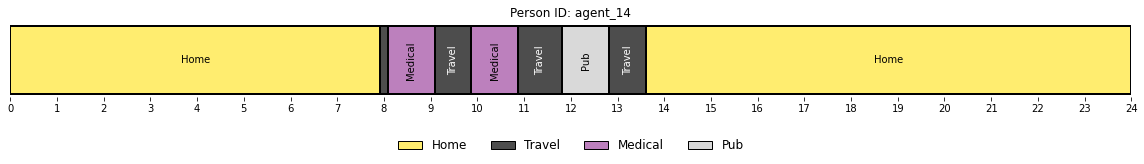

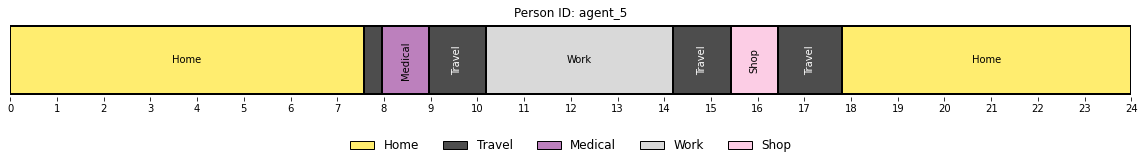

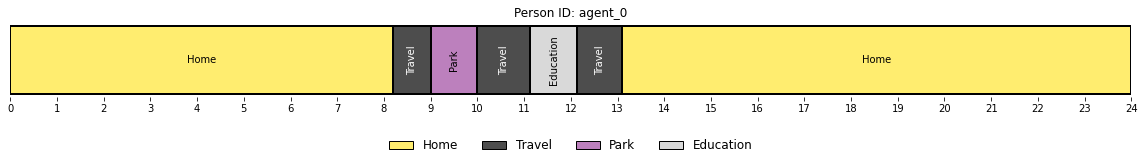

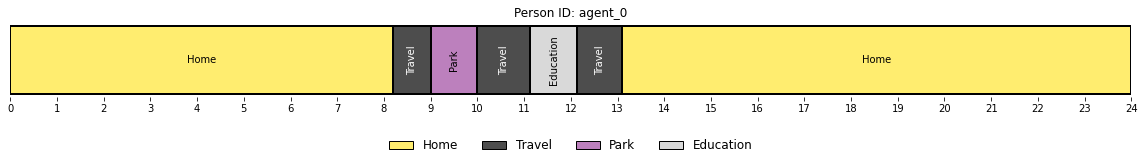

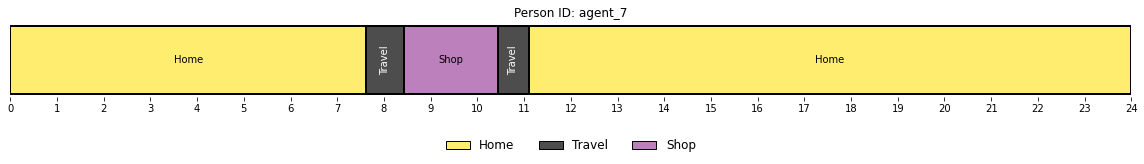

In [20]:
for i in range(5):
    p = population.random_person()
    p.plot()

Plot the frequency with which each of the activity types happens throughout the 24-hour period.

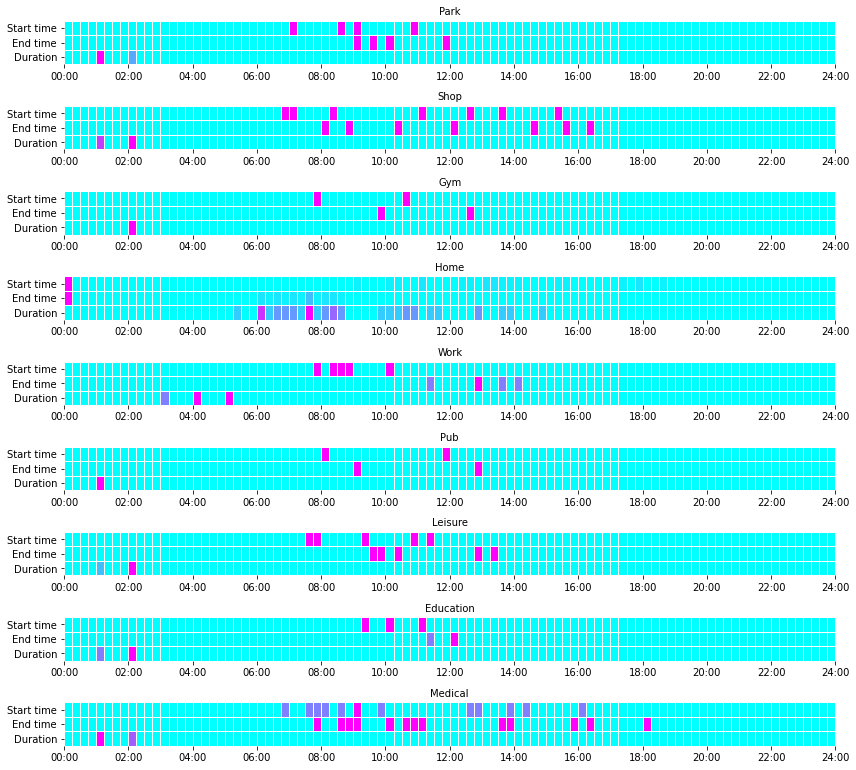

In [21]:
fig = plot_activity_times(population)

In [22]:
# Check the duration of trips
durations = duration_counts(population)
durations

,duration,trips
0,0 to 5 min,0
1,5 to 10 min,1
2,10 to 15 min,2
3,15 to 30 min,10
4,30 to 45 min,10
5,45 to 60 min,19
6,60 to 90 min,19
7,90 to 120 min,0
8,120+ min,0


Now plot a histogram for duration of the trips.

(-0.8400000000000001, 7.0)

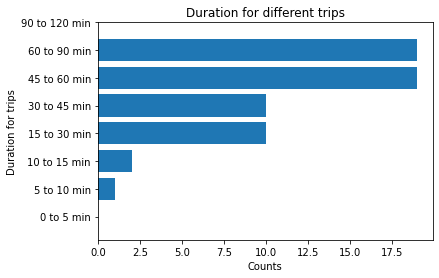

In [23]:
plt.barh(durations["duration"], durations["trips"])
plt.xlabel("Counts")
plt.ylabel("Duration for trips")
plt.title("Duration for different trips")
plt.ylim(ymax = "90 to 120 min")

In [24]:
# Check the distance of trips
distances  = distance_counts(population)
distances

,distance,trips
0,0 to 1 km,4
1,1 to 5 km,50
2,5 to 10 km,7
3,10 to 25 km,0
4,25 to 50 km,0
5,50 to 100 km,0
6,100 to 200 km,0
7,200+ km,0


Next we plot the distribution of trip distances.

(-0.79, 4.0)

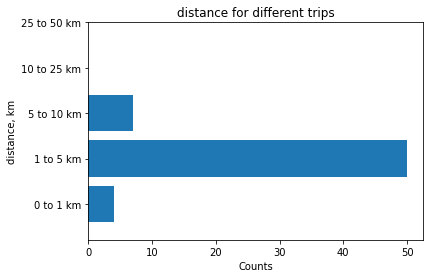

In [25]:
plt.barh(distances["distance"], distances["trips"])
plt.xlabel("Counts")
plt.ylabel("distance, km")
plt.title("distance for different trips")
plt.ylim(ymax = "25 to 50 km")

## Export intermediate CSV tables of population

In [26]:
to_csv(population, dir = "outputs", crs = "epsg:27700")

Plot the distribution of activities by type

Text(0.5, 1.0, 'activities count')

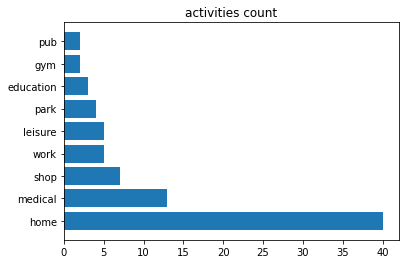

In [27]:
df_activity = pd.read_csv(os.path.join("outputs", "activities.csv"))
totals = df_activity.activity.value_counts()
plt.barh(totals.index, totals)
plt.title("activities count")

In [28]:
write_od_matrices(population, path = "outputs")
od_matrices = pd.read_csv(os.path.join("outputs", "total_od.csv"))  # we should change this method to be consistent with other - ie return a dataframe
od_matrices["total origins"] = od_matrices.drop("Origin", axis=1).sum(axis=1)
od_matrices

,Origin,Hammersmith and Fulham 010B,Hammersmith and Fulham 012B,Hammersmith and Fulham 012F,Hammersmith and Fulham 018B,Hammersmith and Fulham 019C,Hammersmith and Fulham 020A,Hammersmith and Fulham 020D,Hammersmith and Fulham 021C,Hammersmith and Fulham 023B,...,Wandsworth 019B,Wandsworth 020B,Westminster 019C,Westminster 019D,Westminster 020E,Westminster 021B,Westminster 021C,Westminster 021D,Westminster 024D,total origins
0,Hammersmith and Fulham 010B,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,Hammersmith and Fulham 012B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Hammersmith and Fulham 012F,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Hammersmith and Fulham 018B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Hammersmith and Fulham 019C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,Hammersmith and Fulham 020A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
6,Hammersmith and Fulham 020D,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
7,Hammersmith and Fulham 021C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
8,Hammersmith and Fulham 023B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,Hammersmith and Fulham 023C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Plot the number of trips originating from each LSOA

Text(0.5, 1.0, 'Total Origins')

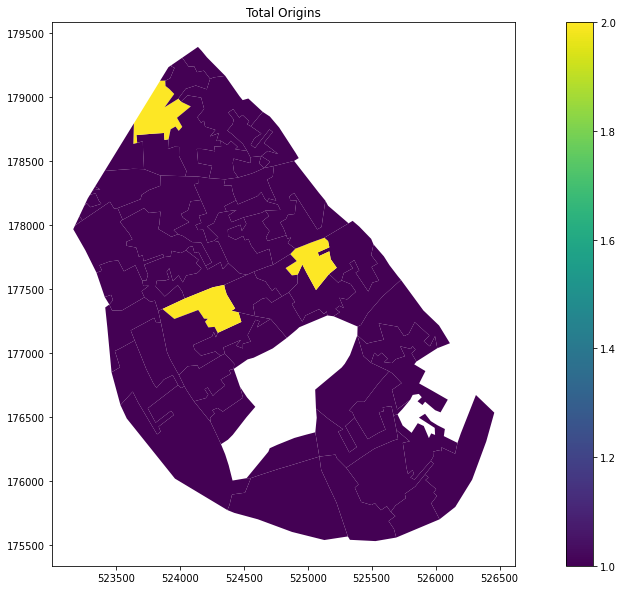

In [29]:
lsoas_clipped = lsoas_clipped.reset_index()
origins_heat_map = lsoas_clipped.join(od_matrices["total origins"])

fig, ax = plt.subplots(figsize=(18,10))    
origins_heat_map.plot("total origins", legend=True, ax=ax)
ax.set_title("Total Origins")

# Reload Tabular Data

We load in the csv files we previously wrote to disk. This replicates a simple synthesis process we might typically use for travel diary survey data.

In [30]:
people = pd.read_csv(os.path.join("outputs", "people.csv")).set_index('pid')
hhs = pd.read_csv(os.path.join("outputs", "households.csv")).set_index('hid')
trips = pd.read_csv(os.path.join("outputs", "legs.csv")).drop(['Unnamed: 0'],axis=1)

trips.rename(columns={'origin activity': 'oact', 'destination activity': 'dact'}, inplace=True)
trips.head()

,pid,hid,freq,ozone,dzone,purp,oact,dact,mode,seq,tst,tet,duration
0,agent_0,hh_0,NaN,Lambeth 004A,Kensington and Chelsea 010D,NaN,home,park,bike,1,1900-01-01 08:11:00,1900-01-01 09:00:00,0:49:00
1,agent_0,hh_0,NaN,Kensington and Chelsea 010D,Lambeth 007A,NaN,park,education,walk,2,1900-01-01 10:00:00,1900-01-01 11:08:00,1:08:00
2,agent_0,hh_0,NaN,Lambeth 007A,Lambeth 004A,NaN,education,home,walk,3,1900-01-01 12:08:00,1900-01-01 13:06:00,0:58:00
3,agent_1,hh_1,NaN,Wandsworth 012D,Lambeth 015D,NaN,home,work,subway,1,1900-01-01 06:53:00,1900-01-01 07:57:00,1:04:00
4,agent_1,hh_1,NaN,Lambeth 015D,Wandsworth 012D,NaN,work,home,rail,2,1900-01-01 12:57:00,1900-01-01 13:12:00,0:15:00


In [31]:
population_reloaded = load_travel_diary(
    trips=trips,
    persons_attributes=people,
    hhs_attributes=hhs,
)

Using from-to activity parser using 'oact' and 'dact' columns


Plot the activities as a 24-hour diary schedules

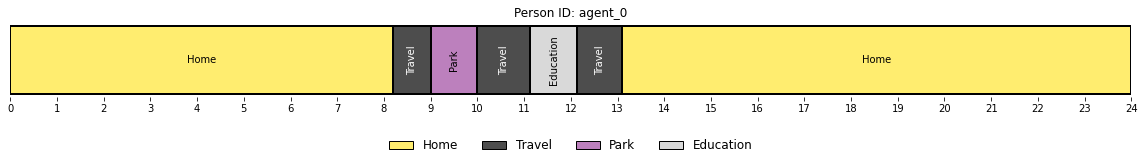

In [32]:
population["hh_0"]["agent_0"].plot()

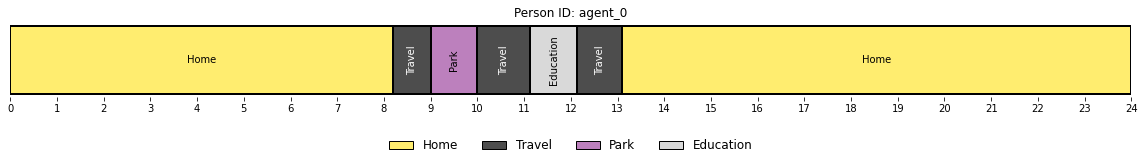

In [33]:
population_reloaded["hh_0"]["agent_0"].plot()

In [34]:
population == population_reloaded

False

The populations are not the same because the csv files did not preserve the coordinates that we previously sampled, so we will sample them again. But the reloaded population will be different as for each location a new coordinate is sampled.

# Write output to MATSim xml

In [35]:
write_matsim(population=population, plans_path=os.path.join("outputs", "population.xml"), version=12)

In [36]:
population_reloaded = read_matsim(
    plans_path=os.path.join("outputs", "population.xml"),
    household_key="hid",
    version=12
)